INFO - Selected columns, dropped duplicates, and created temporary views.
INFO - Top 10 countries with most customers


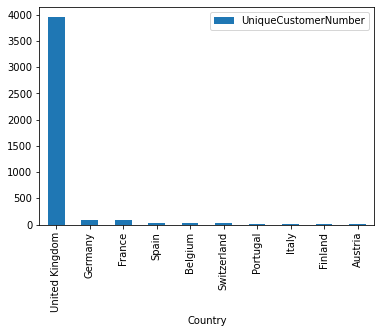

INFO - Customers Ordering The Most


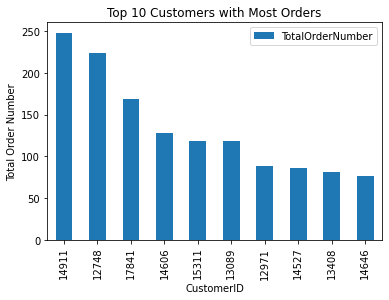

INFO - Distribution of Items Per Order


+---------+-------------+
|StockCode|Invoice_count|
+---------+-------------+
|    22121|          139|
|    21259|          294|
|    22728|          799|
|    23318|          383|
|    22596|          268|
|    21452|          197|
|    21889|          590|
|    90143|           20|
|    21249|          119|
|    21894|          131|
|    22254|           61|
|    21248|           68|
|    84881|            8|
|    23459|           21|
|   90197B|           27|
|    20868|           46|
|    90022|           21|
|    21331|            8|
|   90210B|            7|
|   85132b|            9|
+---------+-------------+
only showing top 20 rows



INFO - Most Ordered Items


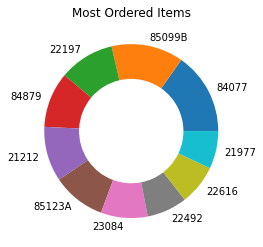

INFO - Price Distribution Per Item


+-------+------------------+
|summary|         UnitPrice|
+-------+------------------+
|  count|             18053|
|   mean| 37.42889724699497|
| stddev|488.91964443633884|
|    min|         -11062.06|
|    max|           38970.0|
+-------+------------------+



INFO - Filtering customers who bought a WHITE METAL LANTERN?


+----------+
|CustomerID|
+----------+
|     16094|
|     13468|
|     17346|
|     15584|
|     17392|
|     17969|
|     14085|
|     17388|
|     14715|
|     12913|
|     16684|
|     15071|
|     17793|
|     14096|
|     18170|
|     17345|
|     15938|
|     15974|
|     17400|
|     17706|
+----------+
only showing top 20 rows



INFO - Most Revenue Generating Items by Country outside UK


+--------------------+------------------+--------------+
|         Description|     total_revenue|       Country|
+--------------------+------------------+--------------+
|              Manual| 934732.7859748424|United Kingdom|
|      DOTCOM POSTAGE|207022.30558659227|United Kingdom|
|REGENCY CAKESTAND...|146811.39265196343|United Kingdom|
|JUMBO BAG RED RET...|109102.70966716348|United Kingdom|
|WHITE HANGING HEA...|107240.80586161303|United Kingdom|
|       PARTY BUNTING| 98625.99695307743|United Kingdom|
|       CHILLI LIGHTS| 68530.36444610778|United Kingdom|
|PAPER CHAIN KIT 5...| 61472.20092320972|United Kingdom|
|ASSORTED COLOUR B...| 58028.35618776674|United Kingdom|
|JUMBO BAG PINK PO...| 49867.37838358455|United Kingdom|
|WOOD BLACK BOARD ...|49818.888682634715|United Kingdom|
|BLACK RECORD COVE...|47893.482692307756|United Kingdom|
|DOORMAT KEEP CALM...| 45140.83142655363|United Kingdom|
|      SPOTTY BUNTING| 39983.82140989726|United Kingdom|
|PICNIC BASKET WIC...|         

INFO - Most Revenue Generating Items by Country in UK


+--------------------+------------------+--------------+
|         Description|     total_revenue|       Country|
+--------------------+------------------+--------------+
|              Manual| 934732.7859748425|United Kingdom|
|      DOTCOM POSTAGE|207022.30558659224|United Kingdom|
|REGENCY CAKESTAND...|146811.39265196343|United Kingdom|
|JUMBO BAG RED RET...|109102.70966716339|United Kingdom|
|WHITE HANGING HEA...|107240.80586161303|United Kingdom|
|       PARTY BUNTING|  98625.9969530774|United Kingdom|
|       CHILLI LIGHTS| 68530.36444610773|United Kingdom|
|PAPER CHAIN KIT 5...| 61472.20092320965|United Kingdom|
|ASSORTED COLOUR B...| 58028.35618776674|United Kingdom|
|JUMBO BAG PINK PO...|49867.378383584575|United Kingdom|
|WOOD BLACK BOARD ...|  49818.8886826347|United Kingdom|
|BLACK RECORD COVE...|47893.482692307756|United Kingdom|
|DOORMAT KEEP CALM...|45140.831426553625|United Kingdom|
|      SPOTTY BUNTING| 39983.82140989729|United Kingdom|
|PICNIC BASKET WIC...|         

In [1]:
import subprocess
import logging
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct
import pandas as pd
import matplotlib.pyplot as plt

# Configure the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
formatter = logging.Formatter("%(levelname)s - %(message)s")
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

class DataOperator:
    def __init__(self, spark):
        self.spark = spark

    def upload_file_to_hdfs(self, local_path, hdfs_path):
        try:
            subprocess.run(["hdfs", "dfs", "-put", local_path, hdfs_path])
            logger.info(f"Uploaded file {local_path} to HDFS path {hdfs_path}")
        except Exception as e:
            logger.error(f"Error uploading file to HDFS: {str(e)}")


    def copy_file_to_hdfs(self, local_path, hdfs_path):
        try:
            subprocess.run(["hdfs", "dfs", "-copyFromLocal", local_path, hdfs_path])
            logger.info(f"Copied file {local_path} to HDFS path {hdfs_path}")
        except Exception as e:
            logger.error(f"Error copying file to HDFS: {str(e)}")

    def select_columns_and_create_views(self, dataframe):
        try:
            customer_columns = ["CustomerID", "Country", "InvoiceDate", "InvoiceNo"]
            df_invoice = dataframe.select(customer_columns).drop_duplicates()
            df_invoice.createOrReplaceTempView("invoices")

            item_columns = ["StockCode", "Description", "UnitPrice", "Quantity", "InvoiceNo"]
            df_items = dataframe.select(item_columns).drop_duplicates()
            df_items.createOrReplaceTempView("items")

            logger.info("Selected columns, dropped duplicates, and created temporary views.")
        except Exception as e:
            logger.error(f"Error selecting columns and creating views: {str(e)}")

    def process_data(self, csv_file_path):
        try:
            # Read data from a CSV file and create a DataFrame
            df = self.spark.read.csv(csv_file_path, header=True, inferSchema=True)

            # Select desired columns and create views
            self.select_columns_and_create_views(df)

            # Top 10 countries with most customers
            logger.info("Top 10 countries with most customers")
            data = self.spark.sql("SELECT Country, COUNT(DISTINCT CustomerID) AS UniqueCustomerNumber \
                                   FROM invoices \
                                   GROUP BY Country \
                                   ORDER BY UniqueCustomerNumber DESC \
                                   LIMIT 10")
            data_df = data.toPandas()
            data_df.plot(kind='bar', x='Country', y='UniqueCustomerNumber')

            plt.show()
            time.sleep(3)  # Add a 3-second delay

            logger.info("Customers With Highest Orders")
            result_df = self.spark.sql("SELECT CustomerID, COUNT(DISTINCT InvoiceNo) as TotalOrderNumber \
                                        FROM invoices where CustomerID is not null \
                                        GROUP BY CustomerID \
                                        ORDER BY TotalOrderNumber DESC \
                                        LIMIT 10")
#             result_df.show()
            result_pandas = result_df.toPandas()
            result_pandas.plot(kind='bar', x='CustomerID', y='TotalOrderNumber')
            plt.title("Top 10 Customers with Highest Orders")
            plt.xlabel("CustomerID")
            plt.ylabel("Total Order Number")
            plt.show()
            time.sleep(3)  # Add a 3-second delay

            logger.info("Distribution of Items Per Order")
            result_df = self.spark.sql("SELECT StockCode, COUNT(DISTINCT InvoiceNo) as Invoice_count \
                                        FROM items \
                                        GROUP BY StockCode")
            result_df.show()
            time.sleep(3)  # Add a 3-second delay

            logger.info("Most Ordered Items")
            most_ordered_items_df = self.spark.sql("SELECT StockCode, Description, SUM(Quantity) AS TotalQuantity \
                                                    FROM items \
                                                    GROUP BY StockCode, Description \
                                                    ORDER BY TotalQuantity DESC \
                                                    LIMIT 10")
            most_ordered_items_pandas_df = most_ordered_items_df.toPandas()
            quantities = most_ordered_items_pandas_df['TotalQuantity']
            labels = most_ordered_items_pandas_df['StockCode']
            plt.pie(quantities, labels=labels, wedgeprops=dict(width=0.4))
            plt.title("Most Ordered Items")
            plt.show()
#             most_ordered_items_df.show()
            time.sleep(3)  # Add a 3-second delay

            logger.info("Price Distribution Per Item")
            price_df = self.spark.sql("SELECT UnitPrice \
                                       FROM items \
                                       GROUP BY StockCode, Description, UnitPrice")
            price_df.describe().show()
            price_df.select('UnitPrice')
            time.sleep(3)  # Add a 3-second delay

            logger.info("Filtering customers who bought a WHITE METAL LANTERN?")
            customers_bought_lantern = self.spark.sql("""
            SELECT DISTINCT invoices.CustomerID
            FROM items
            JOIN invoices ON items.InvoiceNo=invoices.InvoiceNo
            WHERE items.Description = 'WHITE METAL LANTERN' 
            AND invoices.CustomerID IS NOT NULL
            """)
            customers_bought_lantern.show()
            time.sleep(5)  # Add a 3-second delay

            logger.info("Most Revenue Generating Items by Country outside UK")
            revenue_per_country = self.spark.sql("""
            SELECT items.Description, avg(items.UnitPrice) * sum(items.Quantity) as total_revenue, invoices.Country
            FROM items
            JOIN invoices ON items.InvoiceNo=invoices.InvoiceNo
            WHERE invoices.Country != "Germany"
            GROUP BY items.Description, invoices.Country
            ORDER BY total_revenue desc, invoices.Country, items.Description
            """)
           
            revenue_per_country.show()
            time.sleep(10)  # Add a 3-second delay

            logger.info("Most Revenue Generating Items by Country in UK")
            revenue_per_uk = self.spark.sql("""
            SELECT items.Description, avg(items.UnitPrice) * sum(items.Quantity) as total_revenue, invoices.Country
            FROM items
            JOIN invoices ON items.InvoiceNo=invoices.InvoiceNo
            WHERE invoices.Country = "United Kingdom"
            GROUP BY items.Description, invoices.Country
            ORDER BY total_revenue desc, invoices.Country, items.Description
            """)
            revenue_per_uk.show()

        except Exception as e:
            logger.error(f"Error processing data: {str(e)}")


# Create a SparkSession
spark = SparkSession.builder \
    .appName("Data Operator") \
    .getOrCreate()

# Instantiate the DataOperator class
data_operator = DataOperator(spark)

# Check if the file is already copied to HDFS
hdfs_file_path = "/user/itv001290/ecommerce.csv"
file_exists = subprocess.run(["hdfs", "dfs", "-test", "-e", hdfs_file_path], stdout=subprocess.PIPE).returncode == 0

if not file_exists:
    # Copy file from local to HDFS
    data_operator.copy_file_to_hdfs("/home/itv001290/pyspark/SparkDF/ecommerce.csv", hdfs_file_path)
    # Wait for 3 seconds
    time.sleep(3)

# Process data
data_operator.process_data(hdfs_file_path)
